### 6장 모델평가와 하이퍼파라미터 튜닝의 모범사례    

##### 6.1 pipeline을 사용한 효율적인 워크플로 

In [9]:
from sklearn.datasets import load_breast_cancer
df  = load_breast_cancer()
X = df.data
y = df.target
print(df.data.shape)
print(df.target.shape)

(569, 30)
(569,)


In [10]:
# 학습, 테스트데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify= y, random_state=1)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                         PCA(n_components = 2),
                         LogisticRegression(random_state=1))


In [12]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f"테스트 정확도 : {test_acc:.3f}")

테스트 정확도 : 0.956


In [13]:
#pipeline시각화
from sklearn import set_config
set_config(display= 'diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

##### 6.2 k-겹 교차검증을 사용한 모델 성능 평가
6.2.1 홀드아웃 방법
* 테스트 데이터셋 또한 반복사용하면 훈련 데이터셋의 일부가됨 좋은 방법이 아님
* 훈련, 검증, 테스트 데이터셋 세개로 나누는 것이 가장 좋은 방법

k-겹 교차검증
* 데이터셋을 k개의 fold로 나누고 1개는 테스트, 나머지는 훈련데이터셋으로 사용해 k번 검증하는 방식

In [14]:
# k겹 교차검증의 구현
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
print(f"{kfold}")
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'폴드: {k+1:02d},'
          f'클래스 분포 : {np.bincount(y_train[train])},'
          f'정확도: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f"\nCV정확도 : {mean_acc:3f}, +/- {std_acc:.3f}")

<generator object _BaseKFold.split at 0x147a61350>
폴드: 01,클래스 분포 : [153 256],정확도: 0.978
폴드: 02,클래스 분포 : [153 256],정확도: 0.935
폴드: 03,클래스 분포 : [153 256],정확도: 0.957
폴드: 04,클래스 분포 : [153 256],정확도: 0.935
폴드: 05,클래스 분포 : [153 256],정확도: 0.913
폴드: 06,클래스 분포 : [153 257],정확도: 0.956
폴드: 07,클래스 분포 : [153 257],정확도: 0.933
폴드: 08,클래스 분포 : [153 257],정확도: 0.956
폴드: 09,클래스 분포 : [153 257],정확도: 0.933
폴드: 10,클래스 분포 : [153 257],정확도: 0.978

CV정확도 : 0.947295, +/- 0.020


In [15]:
# 사이킷 런을 사용한 k-겹교차검증
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv = 10,
                         n_jobs=1)
print(scores)
print(f"정확도 : {np.mean(scores):.3f},"
      f"분산 : {np.std(scores):.3f}")

[0.97826087 0.93478261 0.95652174 0.93478261 0.91304348 0.95555556
 0.93333333 0.95555556 0.93333333 0.97777778]
정확도 : 0.947,분산 : 0.020


### 6.3.2 검증곡선으로 과대적합, 과소적합 조사


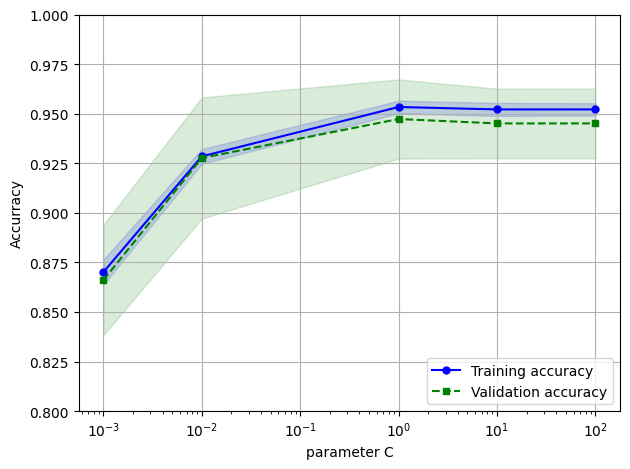

In [21]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
param_range = [0.001, 0.01, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name = 'logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores,axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std  = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
         color='blue', marker="o",
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std, 
                 train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',marker='s',
         markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean+test_std,test_mean-test_std, color='green',
                 alpha=0.15)

plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('parameter C')
plt.ylabel('Accurracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()


In [23]:
# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range,
               'svc__kernel' : ['linear']},
               {'svc__C' : param_range,
                'svc__gamma' : param_range,
                'svc__kernel' : ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  refit = True,
                  n_jobs= -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.9758454106280192
{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [24]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"테스트 정확도 : {clf.score(X_test, y_test):.3f}")

테스트 정확도 : 0.982


In [25]:
# random search hyper param tunning
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range,
               'svc__kernel' : ['linear']},
               {'svc__C' : param_range,
                'svc__gamma' : param_range,
                'svc__kernel' : ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)



0.9758454106280192
{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10.0}


In [28]:
# SHmethod
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc,param_distributions=param_grid,
                           n_candidates='exhaust',
                           resource='n_samples',
                           factor=1.5,random_state=1,n_jobs=-1)

hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)
clf = hs.best_estimator_
print(f"{clf.score(X_test, y_test)}")

0.9705882352941178
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100.0}
0.9824561403508771


In [29]:
# 중첩 교차검증을 사용한 알고리즘 선택
# k겹 교차검증에 훈련폴드를 훈련폴드와 검증폴드로 나누어 하이퍼 파라미터 탐색 후 학습 진행 
scores = cross_val_score(gs,X_train, y_train, scoring='accuracy',cv=5)
print(f"정확도 : {np.mean(scores):.3f}"
      f"+/- {np.std(scores):.3f}")

정확도 : 0.969+/- 0.004
